# Adversarial deep learning

import os
from cleverhans.attacks import FastGradientMethod
from io import BytesIO
import IPython.display
import numpy as np
import pandas as pd
from PIL import Image
from scipy.misc import imread
from scipy.misc import imsave
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception


slim = tf.contrib.slim
tensorflow_master = ""
checkpoint_path   = "../input/model/inception_v3.ckpt"
data_dir          = "../input/data/data.csv"
image_path         = "../input/image"
output_dir        = "../output"
max_epsilon       = 16.0
image_width       = 299
image_height      = 299
batch_size        = 16
resized_image     =[1,299,299,3]
eps = 2.0 * max_epsilon / 255.0
batch_shape = [batch_size, image_height, image_width, 3]
num_classes = 1001
y_pred      = tf.placeholder(tf.float32, shape=(1,1008))

In [ ]:
def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in sorted(tf.gfile.Glob(os.path.join(input_dir, '*.png'))):
        with tf.gfile.Open(filepath, "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [ ]:
class Inception(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False

    def __call__(self, x_input):
        """Constructs model and return probabilities for given input."""
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            _, end_points = inception.inception_v3(
                            x_input, num_classes=self.num_classes, is_training=False,
                            reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        probs = output.op.inputs[0]
        return probs

In [182]:
slim = tf.contrib.slim
tensorflow_master = ""
num_classes = 1001
max_epsilon       = 16.0
image_width       = 299
image_height      = 299
batch_size        = 16

Here's an example of one of the images in the development set


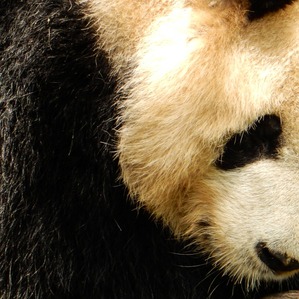

In [183]:
categories = pd.read_csv("../input/categories.csv")
image_classes = pd.read_csv("../input/images/images.csv")
image_iterator = load_images(input_dir, batch_shape)

# get first batch of images
filenames, images = next(image_iterator)

image_metadata = pd.DataFrame({"ImageId": [f[:-4] for f in filenames]}).merge(image_classes,
                                                                              on="ImageId")
true_classes = image_metadata["TrueLabel"].tolist()
target_classes = true_labels = image_metadata["TargetClass"].tolist()
true_classes_names = (pd.DataFrame({"CategoryId": true_classes})
                        .merge(categories, on="CategoryId")["CategoryName"].tolist())
target_classes_names = (pd.DataFrame({"CategoryId": target_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

print("Here's an example of one of the images in the development set")
show_image(images[0])

In [184]:
def load_target_class(input_dir):
    with tf.gfile.Open(os.path.join(input_dir, '../images.csv')) as f:
        next(f) # skip header
        return {row[0]+".png": int(row[6]) for row in csv.reader(f) if len(row) >= 7}

def save_images(images, filenames, output_dir):
    for i, filename in enumerate(filenames):
        with tf.gfile.Open(os.path.join(output_dir, filename), 'wb') as f:
            imsave(f, (images[i, :, :, :] + 1.0) * 0.5, format='png')

In [185]:
session = tf.Session()

The original image is on the left, and the targeted adversarial image is on the right. Again, they look very similar, don't they? It's very clear both are butterflies


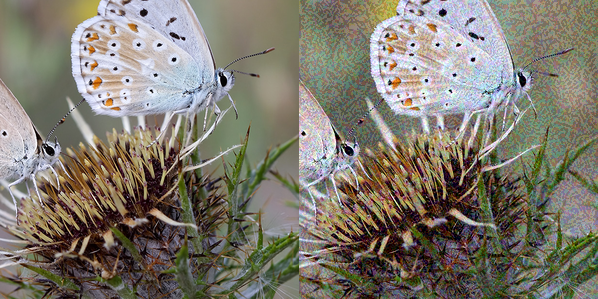

In [186]:
eps = 2.0 * max_epsilon / 255.0
batch_shape = [batch_size, image_height, image_width, 3]
num_classes = 1001

categories = pd.read_csv("../input/categories/categories.csv")
image_classes = pd.read_csv("../input/images/images.csv")
image_iterator = load_images(input_dir, batch_shape)

# get first batch of images
filenames, images = next(image_iterator)

image_metadata = pd.DataFrame({"ImageId": [f[:-4] for f in filenames]}).merge(image_classes,
                                                                              on="ImageId")

all_images_target_class = {image_metadata["ImageId"][i]+".png": image_metadata["TargetClass"][i]
                           for i in image_metadata.index}

with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, end_points = inception.inception_v3(
            x_input, num_classes=num_classes, is_training=False)

    target_class_input = tf.placeholder(tf.int32, shape=[batch_size])
    one_hot_target_class = tf.one_hot(target_class_input, num_classes)
    cross_entropy = tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                    logits,
                                                    label_smoothing=0.1,
                                                    weights=1.0)
    cross_entropy += tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                     end_points['AuxLogits'],
                                                     label_smoothing=0.1,
                                                     weights=0.4)
    x_adv = x_input - eps * tf.sign(tf.gradients(cross_entropy, x_input)[0])
    x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
        scaffold=tf.train.Scaffold(saver=saver),
        checkpoint_filename_with_path=checkpoint_path,
        master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        target_class_for_batch = ([all_images_target_class[n] for n in filenames]
                                  + [0] * (batch_size - len(filenames)))
        targeted_images = sess.run(x_adv,
                                   feed_dict={x_input: images,
                                              target_class_input: target_class_for_batch})
        

show_image(np.concatenate([images[2], targeted_images[2]], axis=1))


In [ ]:
session.close()